# Exploratory Data Analysis of the preprocessed Data


In [19]:
# Setup
import pandas as pd
import random
import torch
import numpy as np
from datasets import Dataset
import matplotlib.pyplot as plt
import warnings
import os
from glob import glob
from collections import Counter
import seaborn as sns
import string
from wordcloud import WordCloud

# Set random seeds for reproducibility
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# load data 
data = pd.read_csv("../data/final_data.csv")

if "Unnamed: 0" in data.columns:
    data = data.drop("Unnamed: 0", axis=1)

### Overview

In [20]:
# Getting to know the data frame
data.info()
data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26660 entries, 0 to 26659
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   speech_text         26660 non-null  object
 1   legislative_period  26660 non-null  int64 
 2   protocol_nr         26660 non-null  int64 
 3   agenda_item_number  26660 non-null  int64 
 4   party               26660 non-null  object
 5   agenda_item_title   25337 non-null  object
 6   date                25337 non-null  object
 7   full_name           26660 non-null  object
dtypes: int64(3), object(5)
memory usage: 1.6+ MB


speech_text  legislative_period  \
count                                               26660        26660.000000   
unique                                              26660                 NaN   
top     Herr Präsident! Kolleginnen und Kollegen! Die ...                 NaN   
freq                                                    1                 NaN   
mean                                                  NaN           19.282671   
std                                                   NaN            0.450306   
min                                                   NaN           19.000000   
25%                                                   NaN           19.000000   
50%                                                   NaN           19.000000   
75%                                                   NaN           20.000000   
max                                                   NaN           20.000000   

         protocol_nr  agenda_item_number    party agenda_item_title  \
count   26660.000000        26660.000000    26660             25337   
unique           NaN                 NaN        6              2104   
top              NaN                 NaN  CDU/CSU   Auswärtiges Amt   
freq             NaN                 NaN     7339               215   
mean      106.794524            7.089085      NaN               NaN   
std        68.444543            5.486578      NaN               NaN   
min         1.000000            1.000000      NaN               NaN   
25%        49.000000            3.000000      NaN               NaN   
50%        89.000000            5.000000      NaN               NaN   
75%       166.000000           10.000000      NaN               NaN   
max       239.000000           35.000000      NaN               NaN   

              date       full_name  
count        25337           26660  
unique         319            1007  
top     2022-05-12  Volker Ullrich  
freq           176             194  
mean           NaN             NaN  
std            NaN             NaN  
min            NaN             NaN  
25%            NaN             NaN  
50%            NaN             NaN  
75%            NaN             NaN  
max            NaN             NaN

In [21]:
# computing basic text statistics


# preparing extra columns:
# editing the speeches in new column: all to lower case, removing all punctuation
data["text_edit"] = data["speech_text"].str.lower().str.translate(str.maketrans('', '', string.punctuation))
# adding column with tokenized speeches
data["tokenized_text"] = data["text_edit"].str.split()
# new column with length of speeches
data["speech_length"] = data["tokenized_text"].str.len()

# getting all speeches into one shared list to investigate words
all_vocab = " ".join(data["text_edit"].astype(str))
all_words = all_vocab.split()
# getting number of all words
vocab_size = len(set(all_words))
# getting most frequent words
word_counts = Counter(all_words)
most_freq = word_counts.most_common(5)

# getting mean and median of speech length
mean_speech_length = np.mean(data["speech_length"])
median_speech_length = np.median(data["speech_length"])

# getting distributions of target variables
pct_parties = round(data["party"].value_counts(normalize = True) * 100, 1)
pct_parties = pct_parties.to_dict()

# printing all investigated stats
print("Looking at speeches:")
print(f"   Number of speeches: {len(data)}")
print(f"   Vocabulary size: {vocab_size}")
print(f"   Average speech length (mean): {mean_speech_length}")
print(f"   Average speech length (median): {median_speech_length}")
print(f"   Most commonly used words: \n   {most_freq}")
print("Output variable parties:")
print(f"   Speaker parties: \n   {data['party'].value_counts().to_dict()}")
print(f"   Speaker parties in pct: \n   {pct_parties}")


Looking at speeches:
   Number of speeches: 26660
   Vocabulary size: 272858
   Average speech length (mean): 646.0859714928732
   Average speech length (median): 616.0
   Most commonly used words: 
   [('die', 593659), ('und', 511646), ('der', 436900), ('das', 329915), ('wir', 320103)]
Output variable parties:
   Speaker parties: 
   {'CDU/CSU': 7339, 'SPD': 5785, 'AfD': 3728, 'GRÜNE': 3550, 'FDP': 3460, 'LINKE': 2798}
   Speaker parties in pct: 
   {'CDU/CSU': 27.5, 'SPD': 21.7, 'AfD': 14.0, 'GRÜNE': 13.3, 'FDP': 13.0, 'LINKE': 10.5}


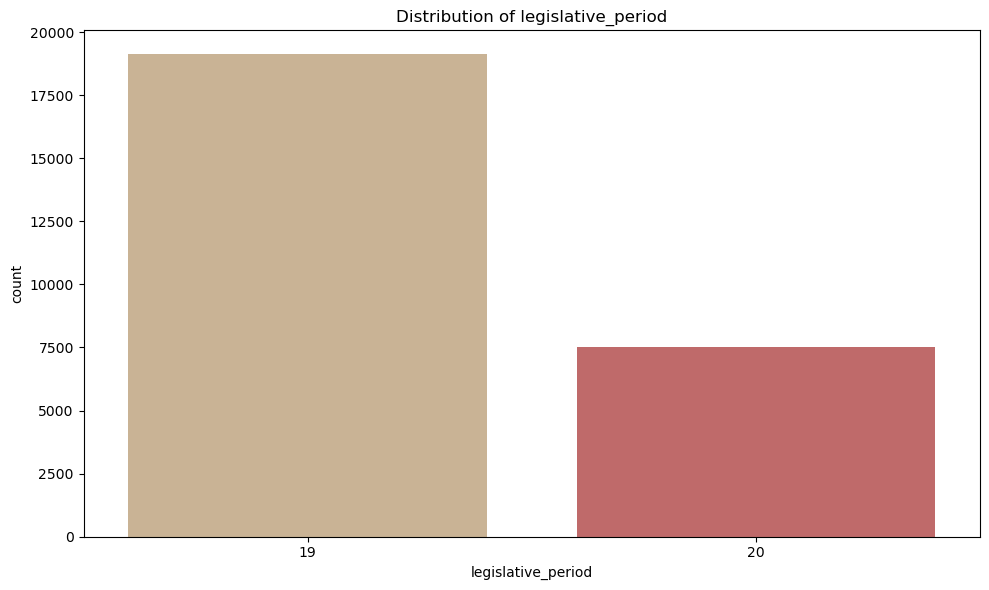

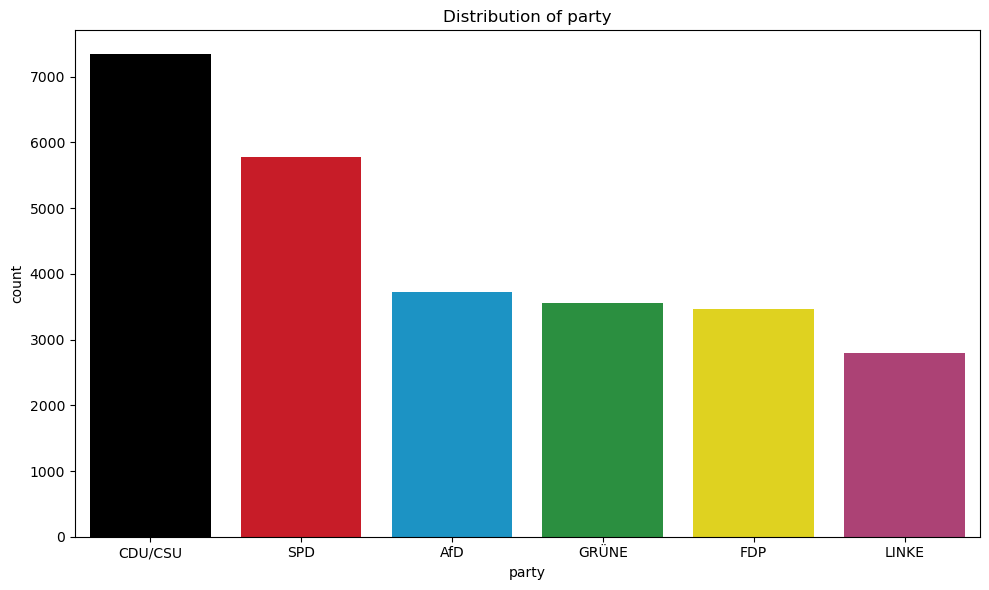

In [22]:
# Visualising features in barplots where information is sensical, to get overview of columns
party_colors = {
    'CDU/CSU': '#000000',              # Black (Schwarz)
    'SPD': '#e3000f',                  # Red (Rot)
    'AfD': '#009ee0',                  # Blue (Blau)
    'GRÜNE': '#1aa036',  # Green (Grün)
    'FDP': '#ffed00',                  # Yellow (Gelb)
    'LINKE': '#be3075',             # Magenta/Pinkish Red

    19 : 'tan',
    20 : 'indianred'
}

# subsetting columns that can be interesting
features_to_plot = ['legislative_period', 'party']

# visualising
for coloumn in features_to_plot:
    order = data[coloumn].value_counts().index
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=coloumn, order = order, palette=party_colors)
    plt.title(f'Distribution of {coloumn}')
    plt.tight_layout()
    plt.show()





### Investigating the speech length (after preprocessing, only 100-1500 words)
- Quantiles
- divided by parties

In [23]:
# printing Quantiles
print("25% Quantile", data["speech_length"].quantile(0.25))
print("50% Quantile", data["speech_length"].quantile(0.5))
print("75% Quantile", data["speech_length"].quantile(0.75))
print("99% Quantile", data["speech_length"].quantile(0.99))



25% Quantile 493.0
50% Quantile 616.0
75% Quantile 762.0
99% Quantile 1314.0


/Users/ellaalle/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Speech Length')

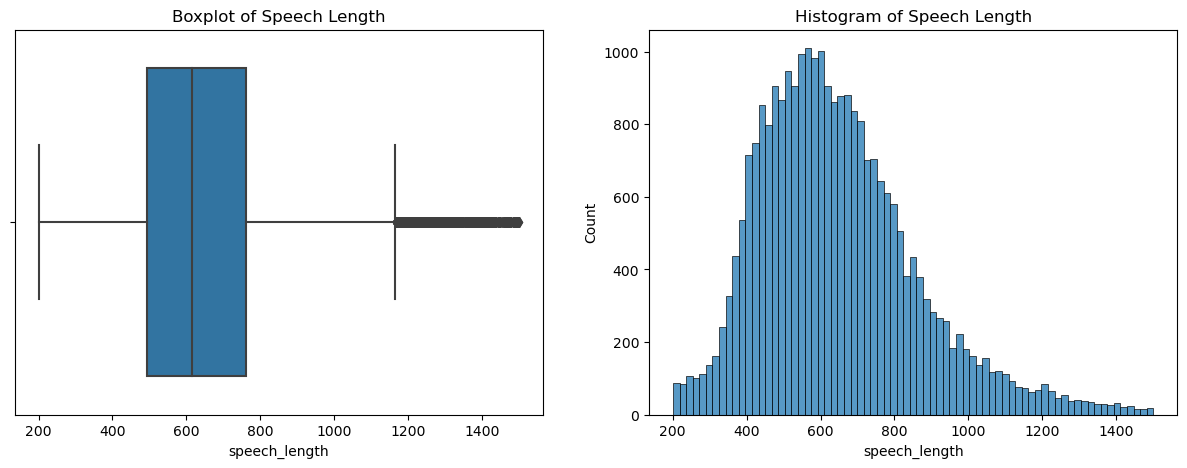

In [24]:
# analysing distribution of speech lengths

# boxplot and histogram
fig, axes = plt.subplots(1, 2, figsize = (15,5))

sns.boxplot(x = data["speech_length"], ax=axes[0])
axes[0].set_title("Boxplot of Speech Length")

sns.histplot(data["speech_length"], ax=axes[1])
axes[1].set_title("Histogram of Speech Length")

In [25]:
# speech characteristics divided by party
party_stats = (
    data.groupby("party")["speech_length"]
    .agg(
        nr_speeches="count",
        min_speech_length = "min",
        max_word_count = "max",
        mean_word_count="mean"
    )
    .reset_index()
)

# quantiles
party_stats["q25_word_count"] = data.groupby("party")["speech_length"].quantile(0.25).values
party_stats["q50_word_count"] = data.groupby("party")["speech_length"].quantile(0.5).values
party_stats["q75_word_count"] = data.groupby("party")["speech_length"].quantile(0.75).values

# sort
party_stats = party_stats.sort_values(by="nr_speeches", ascending=False)
party_stats


party  nr_speeches  min_speech_length  max_word_count  mean_word_count  \
1  CDU/CSU         7339                201            1500       723.704728   
5      SPD         5785                205            1496       682.782887   
0      AfD         3728                201            1497       593.002146   
3    GRÜNE         3550                202            1492       600.491831   
2      FDP         3460                203            1458       597.484393   
4    LINKE         2798                201            1468       555.300214   

   q25_word_count  q50_word_count  q75_word_count  
1           572.0           697.0          846.00  
5           531.0           652.0          799.00  
0           470.0           572.0          685.25  
3           449.0           564.5          719.00  
2           467.0           569.0          700.00  
4           424.0           521.0          658.00

/Users/ellaalle/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ellaalle/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ellaalle/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ellaalle/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.

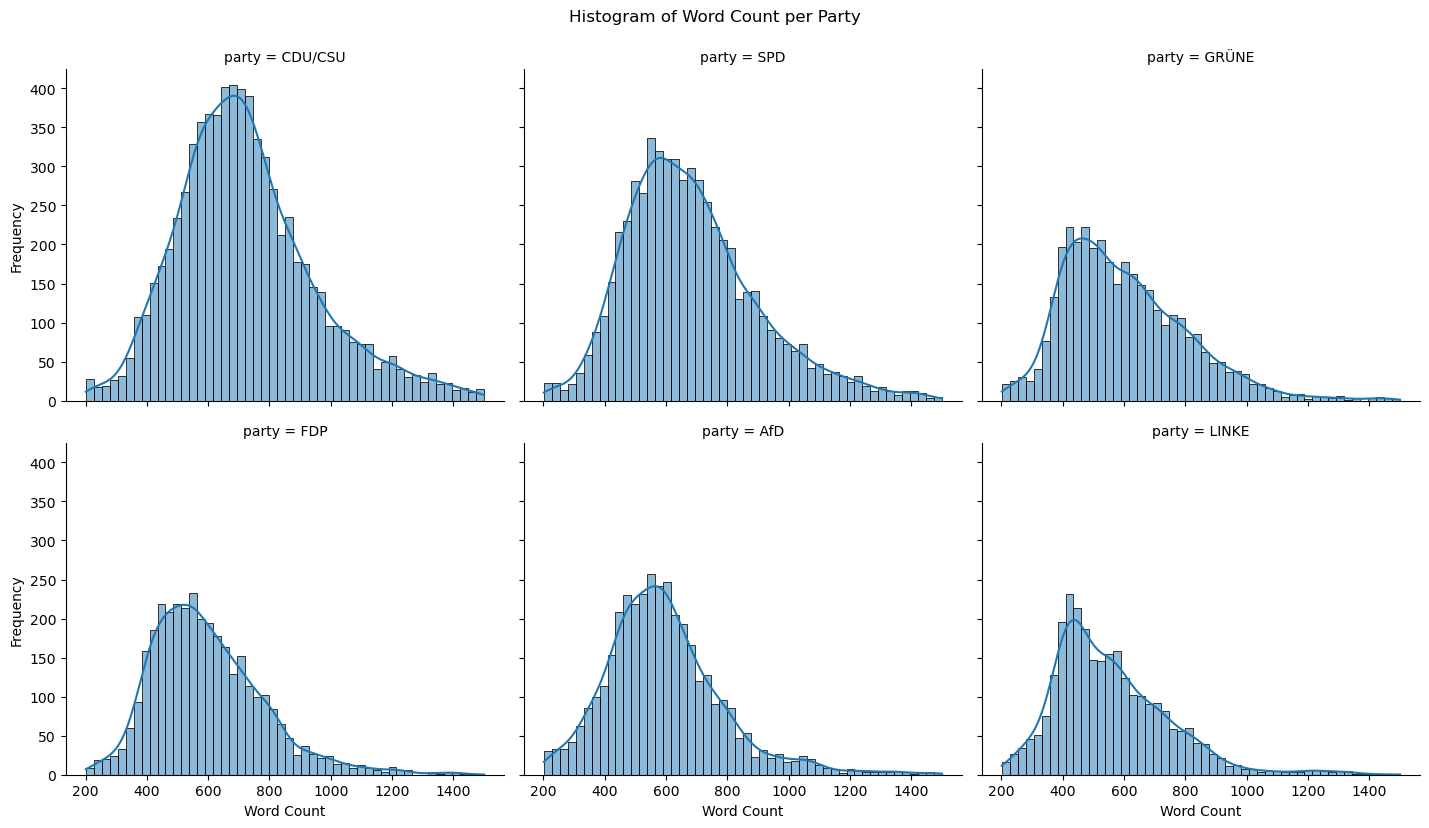

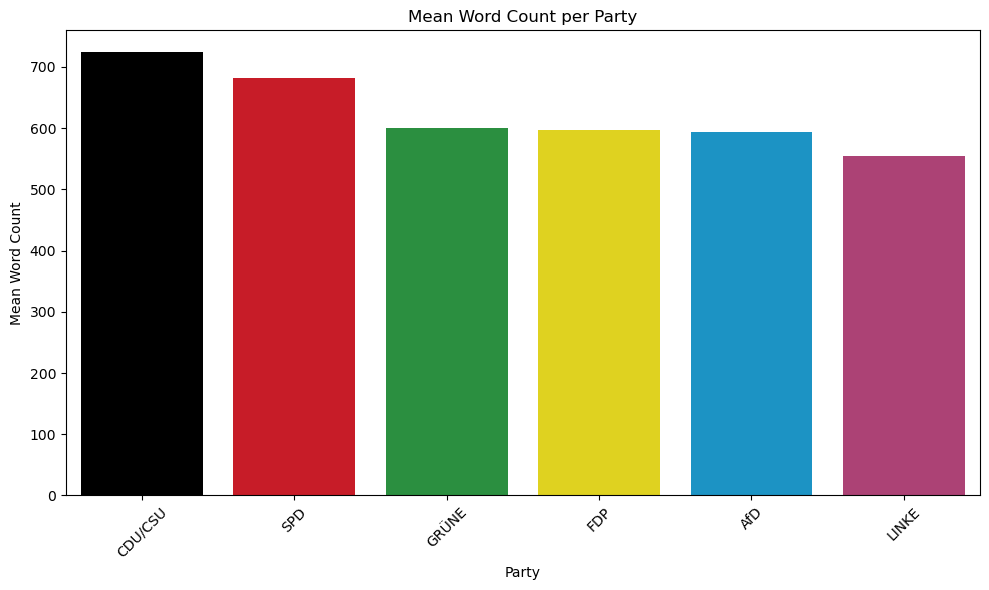

In [26]:
# Visualizing word count of speeches per party 

g = sns.displot(
    data=data,
    x="speech_length",
    col="party",        
    col_wrap=3,            
    bins=50,               
    kde=True,             
    facet_kws={
        'sharex': True,    
        'sharey': True     
    },
    height=4,              
    aspect=1.2             
)

g.set_axis_labels("Word Count", "Frequency")
g.fig.suptitle("Histogram of Word Count per Party", y=1.03)
plt.show()

# Barplot
plot_data_2 = party_stats.sort_values(by="mean_word_count", ascending=False)

fig, ax = plt.subplots(figsize=(10, 6)) 

sns.barplot(data=plot_data_2, x="party", y="mean_word_count", ax=ax, palette=party_colors)
ax.set_title("Mean Word Count per Party")
ax.set_xlabel("Party")
ax.set_ylabel("Mean Word Count")
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Investigating the number of speeches divided by parties

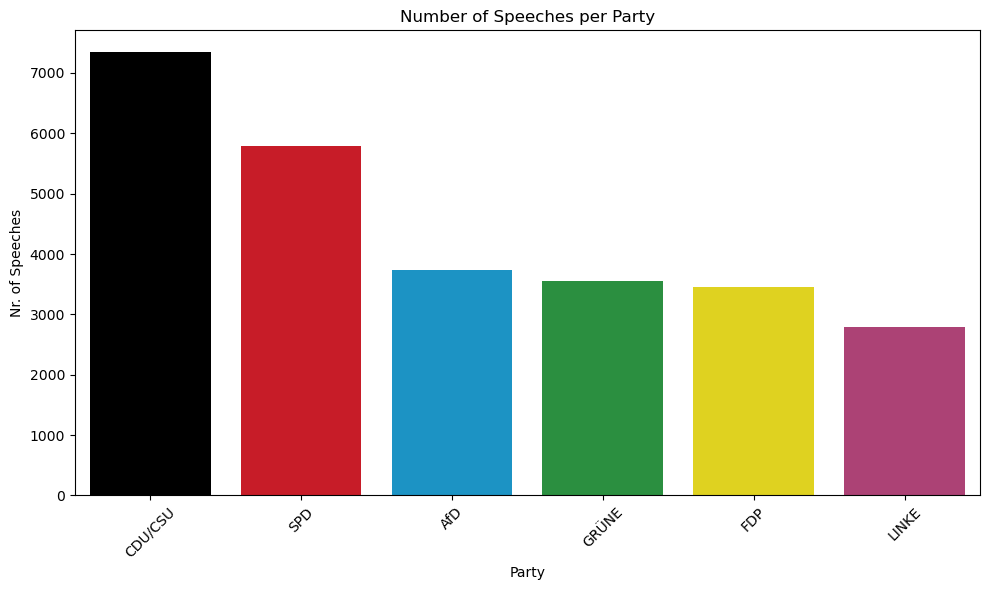

In [27]:
# Visualizing number of speeches per party

# sort
plot_data_1 = party_stats.sort_values(by="nr_speeches", ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=plot_data_1, x="party", y="nr_speeches", ax=ax, palette=party_colors)
ax.set_title("Number of Speeches per Party")
ax.set_xlabel("Party")
ax.set_ylabel("Nr. of Speeches")
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

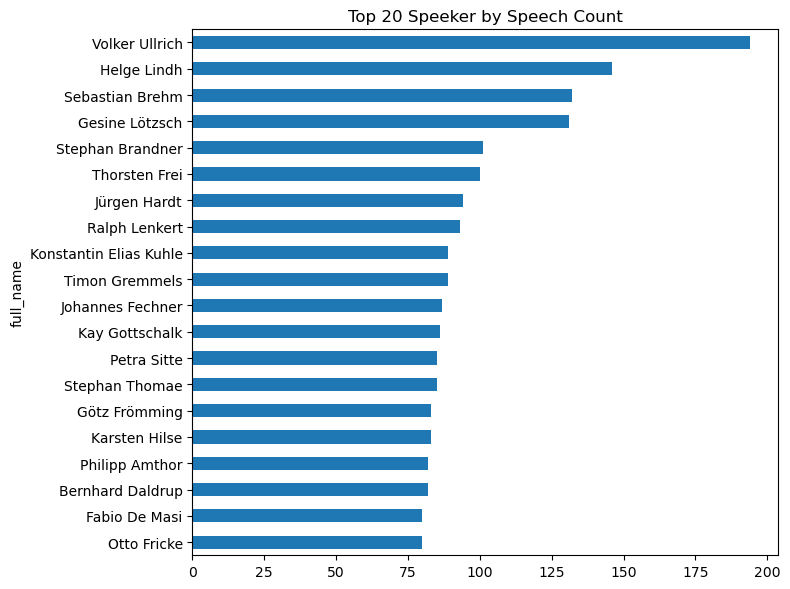

In [28]:
# visualizing top 20 speaker by speech count
top_speakers = data["full_name"].value_counts().head(20)

top_speakers.plot(kind="barh", figsize=(8, 6), title="Top 20 Speeker by Speech Count")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Investigating speech content
- common words overall
- divided by parties

In [29]:
# preparing stopwords

# importing german stopword list from github
# link: https://github.com/solariz/german_stopwords
with open("german_stopwords_full.txt", "r", encoding="utf-8") as g:
    german_stopwords_full = [line.strip() for line in g if not line.lstrip().startswith(";")]

# maybe list of words to add to stopwords:
more_stopwords = ["damen", "herren", "herr", "kollegen", "kolleginnen", "menschen", "deutschland", "liebe", "präsident", "präsidentin"]

# add list of additional words
german_stopwords_full.extend(more_stopwords)

In [30]:
# add wordcounts
data['clean_full'] = data['tokenized_text'].apply(lambda tokens: [word for word in tokens if word not in german_stopwords_full and word.isalpha()])

# Flatten all tokens into a single list
all_tokens = [token for tokens in data['clean_full'] for token in tokens]

# Count word frequencies
word_counts = Counter(all_tokens)

# Get top 10 most common words
top_10 = word_counts.most_common(10)

# Display
for word, count in top_10:
    print(f"{word}: {count}")

euro: 26192
antrag: 19582
land: 19087
bundesregierung: 17573
jahren: 16615
prozent: 15987
frage: 15913
jahr: 15869
thema: 14058
deutschen: 13677


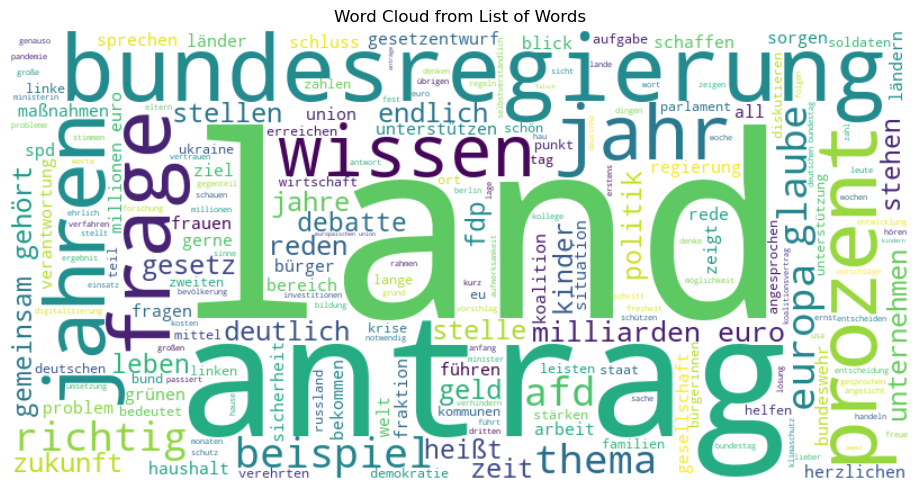

In [31]:
# visualising shared word cloud - speech segmentation

# joining all speech text into a single string
text = ' '.join(all_words)

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=german_stopwords_full).generate(text)

# Displaying it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud from List of Words")
plt.tight_layout()
plt.show()

In [32]:
# add wordcounts per party

# Group by party and compute top 10 words per party
top_words_per_party = {}

for party, group in data.groupby('party'):
    tokens = [word for tokens in group['clean_full'] for word in tokens]
    word_counter = Counter(tokens)
    top_10 = word_counter.most_common(10)
    top_words_per_party[party] = [f"{word} ({count})" for word, count in top_10]

#  Create df with results to display
result_df = pd.DataFrame(top_words_per_party, index=[f"Top {i+1}" for i in range(10)])
result_df



AfD         CDU/CSU                     FDP  \
Top 1              euro (4059)     euro (8091)  bundesregierung (2549)   
Top 2         deutschen (3156)   antrag (6308)           antrag (2521)   
Top 3   bundesregierung (3047)     land (5944)             euro (2331)   
Top 4            antrag (3031)    frage (5734)             land (2237)   
Top 5              land (2784)    thema (5629)            frage (2092)   
Top 6           prozent (2718)     jahr (5290)           jahren (1999)   
Top 7               afd (2664)  kollege (5174)          kollege (1947)   
Top 8            bürger (2448)  prozent (5148)             jahr (1868)   
Top 9         regierung (2416)   jahren (5023)            thema (1767)   
Top 10           jahren (2159)   glaube (4774)       demokraten (1738)   

                         GRÜNE                   LINKE              SPD  
Top 1           endlich (2668)             euro (3342)      euro (5774)  
Top 2              euro (2595)  bundesregierung (2929)      land (4442)  
Top 3   bundesregierung (2569)            linke (2676)    antrag (3830)  
Top 4            jahren (2312)          endlich (2202)    jahren (3456)  
Top 5              land (2227)          prozent (2019)     frage (3369)  
Top 6            antrag (2194)           antrag (1698)  deutlich (3295)  
Top 7             frage (2098)           jahren (1666)      jahr (3282)  
Top 8             union (1829)             jahr (1606)   richtig (3266)  
Top 9              jahr (1813)       milliarden (1497)     thema (3157)  
Top 10           wissen (1694)         beispiel (1494)  beispiel (3141)

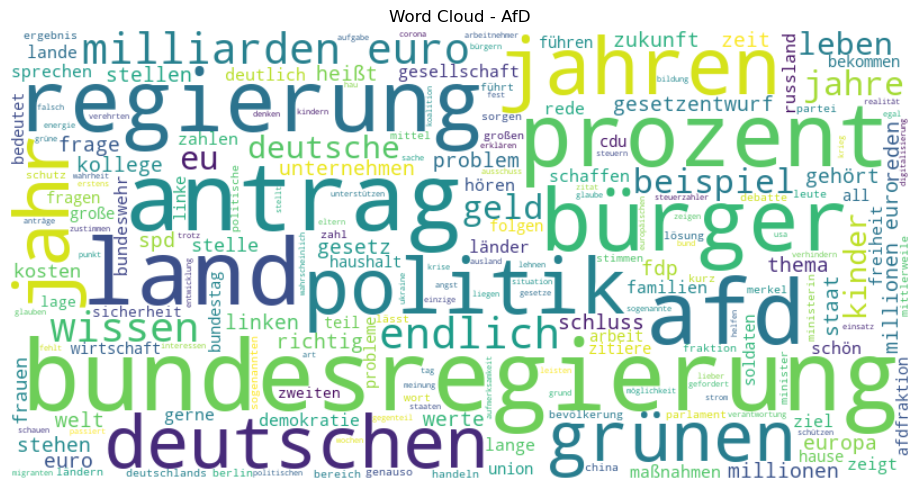

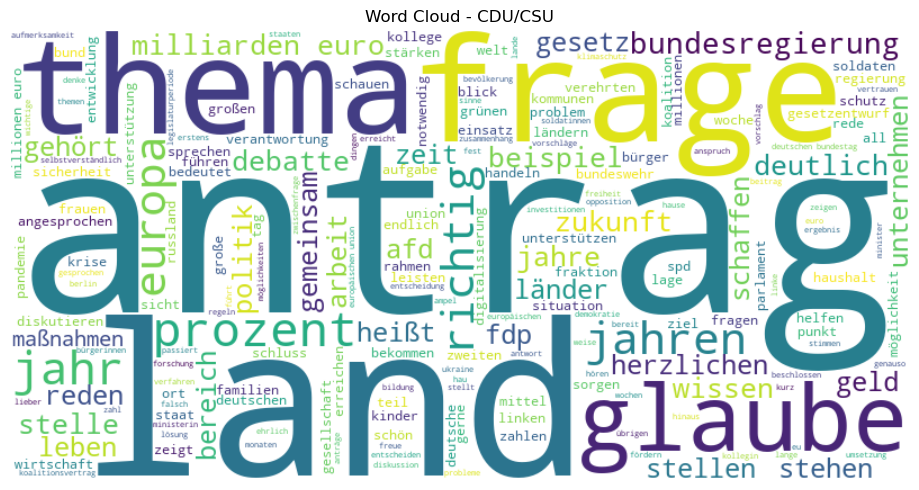

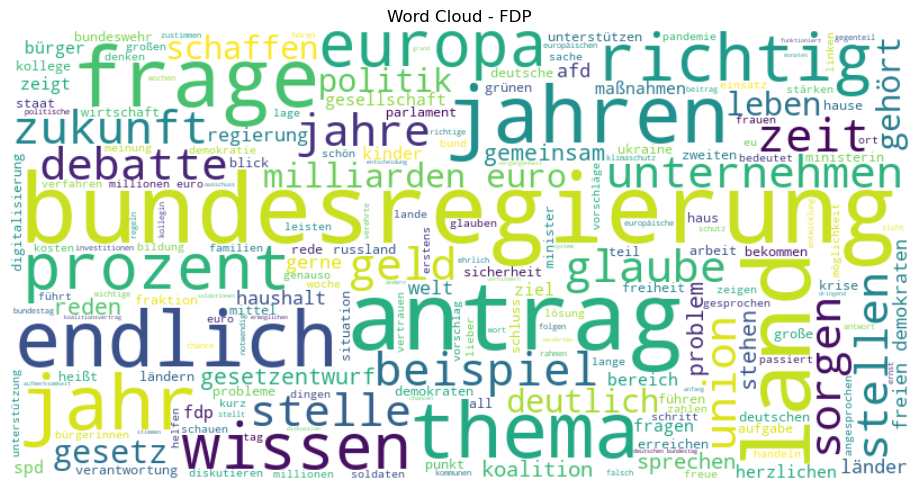

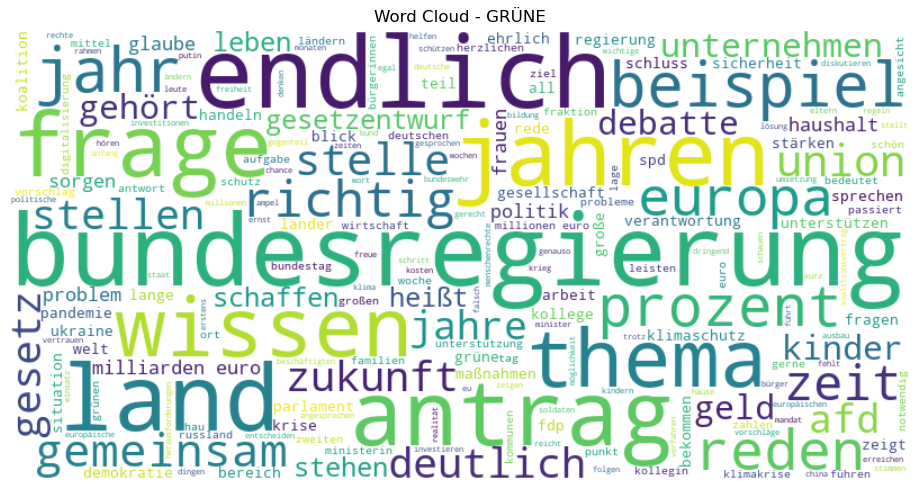

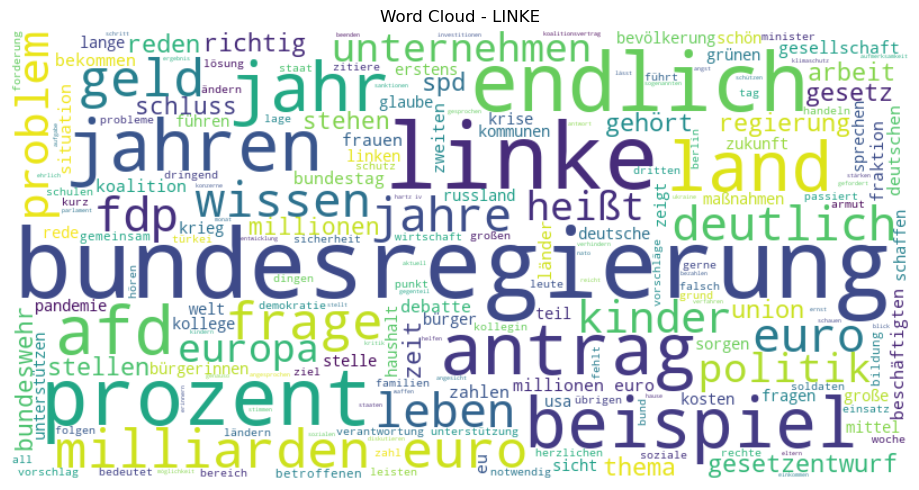

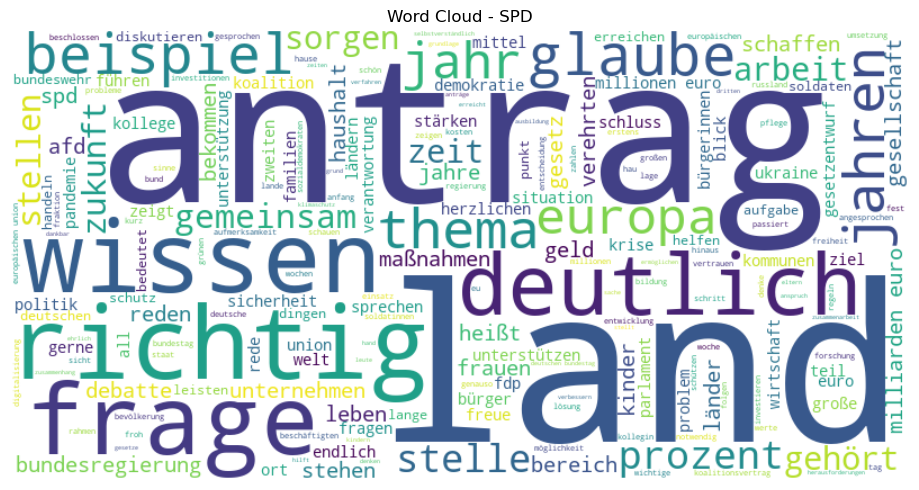

In [33]:
# word cloud per party

# grouping words by party
party_words = data.groupby('party')['tokenized_text'].sum()

# creating seperate wordclouds per party
for party, words in party_words.items():
    text = ' '.join(words)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=german_stopwords_full).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {party}")
    plt.tight_layout()
    plt.show()

### Topic Modelling

In [34]:
# Get most common agenda titles overall:

# drop NaNs
clean_titles = data["agenda_item_title"].dropna()

# count identical full topic titles
topic_counts = Counter(clean_titles)

# get top 20 most common full titles
top_20_topics = topic_counts.most_common(20)

# display
print("Top 20 full topic titles:")
for topic, count in top_20_topics:
    print(f"    {topic}: {count}")


Top 20 full topic titles:
    Auswärtiges Amt: 215
    Verteidigung: 211
    Wirtschaftliche Zusammenarbeit und Entwicklung: 207
    Bildung und Forschung: 191
    Gesundheit: 191
    Abschließende Beratungen ohne Aussprache: 170
    Ernährung und Landwirtschaft: 170
    Familie, Senioren, Frauen und Jugend: 159
    Überweisungen im vereinfachten Verfahren: 144
    Arbeit und Soziales: 127
    Umwelt, Naturschutz und nukleare Sicherheit: 119
    Bundeskanzlerin und Bundeskanzleramt: 115
    Justiz und Verbraucherschutz: 102
    Verkehr und digitale Infrastruktur: 93
    Bundeswehreinsatz in Südsudan (UNMISS): 88
    Bundeswehreinsatz in Mali (MINUSMA): 88
    Digitales und Verkehr: 82
    Bundeswehreinsatz in Kosovo (KFOR): 74
    Wirtschaft und Energie: 73
    Regierungserklärung zum Europäischen Rat: 71


In [35]:
# Get most common agenda titles by parties:

data_filtered = data.dropna(subset=['agenda_item_title'])
# dict to hold top topics per party
top_titles_per_party = {}

# group by party and get top 10 full agenda titles
for party, group in data_filtered.groupby('party'):
    titles = group['agenda_item_title']
    title_counter = Counter(titles)
    top_10 = title_counter.most_common(10)
    top_titles_per_party[party] = [f"{title} ({count})" for title, count in top_10]

# create df
result_df = pd.DataFrame(top_titles_per_party, index=[f"Top {i+1}" for i in range(10)])
result_df
# almost identical topics in slightly different order of importance!

AfD  \
Top 1   Wirtschaftliche Zusammenarbeit und Entwicklung...   
Top 2                                Auswärtiges Amt (31)   
Top 3                   Ernährung und Landwirtschaft (30)   
Top 4                                   Verteidigung (28)   
Top 5                          Bildung und Forschung (27)   
Top 6                                     Gesundheit (27)   
Top 7       Abschließende Beratungen ohne Aussprache (27)   
Top 8           Bundeskanzlerin und Bundeskanzleramt (25)   
Top 9           Familie, Senioren, Frauen und Jugend (22)   
Top 10      Überweisungen im vereinfachten Verfahren (20)   

                                                  CDU/CSU  \
Top 1                                Auswärtiges Amt (61)   
Top 2                                   Verteidigung (54)   
Top 3   Wirtschaftliche Zusammenarbeit und Entwicklung...   
Top 4                                     Gesundheit (49)   
Top 5       Abschließende Beratungen ohne Aussprache (48)   
Top 6                          Bildung und Forschung (46)   
Top 7       Überweisungen im vereinfachten Verfahren (43)   
Top 8                   Ernährung und Landwirtschaft (42)   
Top 9           Familie, Senioren, Frauen und Jugend (40)   
Top 10   Umwelt, Naturschutz und nukleare Sicherheit (32)   

                                                      FDP  \
Top 1                                   Verteidigung (32)   
Top 2   Wirtschaftliche Zusammenarbeit und Entwicklung...   
Top 3                                Auswärtiges Amt (28)   
Top 4                                     Gesundheit (26)   
Top 5                          Bildung und Forschung (25)   
Top 6       Abschließende Beratungen ohne Aussprache (23)   
Top 7           Familie, Senioren, Frauen und Jugend (21)   
Top 8                   Ernährung und Landwirtschaft (21)   
Top 9       Überweisungen im vereinfachten Verfahren (20)   
Top 10                           Arbeit und Soziales (18)   

                                                    GRÜNE  \
Top 1                                Auswärtiges Amt (37)   
Top 2   Wirtschaftliche Zusammenarbeit und Entwicklung...   
Top 3                          Bildung und Forschung (30)   
Top 4                                     Gesundheit (30)   
Top 5                                   Verteidigung (26)   
Top 6                   Ernährung und Landwirtschaft (26)   
Top 7           Familie, Senioren, Frauen und Jugend (21)   
Top 8       Abschließende Beratungen ohne Aussprache (20)   
Top 9                            Arbeit und Soziales (19)   
Top 10      Überweisungen im vereinfachten Verfahren (19)   

                                                    LINKE  \
Top 1                                   Verteidigung (24)   
Top 2                          Bildung und Forschung (22)   
Top 3   Wirtschaftliche Zusammenarbeit und Entwicklung...   
Top 4           Familie, Senioren, Frauen und Jugend (20)   
Top 5                                     Gesundheit (20)   
Top 6       Abschließende Beratungen ohne Aussprache (17)   
Top 7                                Auswärtiges Amt (16)   
Top 8                            Arbeit und Soziales (16)   
Top 9                   Ernährung und Landwirtschaft (16)   
Top 10   Umwelt, Naturschutz und nukleare Sicherheit (15)   

                                                      SPD  
Top 1                                   Verteidigung (47)  
Top 2                                Auswärtiges Amt (42)  
Top 3   Wirtschaftliche Zusammenarbeit und Entwicklung...  
Top 4                          Bildung und Forschung (41)  
Top 5                                     Gesundheit (39)  
Top 6           Bundeskanzlerin und Bundeskanzleramt (38)  
Top 7           Familie, Senioren, Frauen und Jugend (35)  
Top 8       Abschließende Beratungen ohne Aussprache (35)  
Top 9                   Ernährung und Landwirtschaft (35)  
Top 10      Überweisungen im vereinfachten Verfahren (29)

In [36]:
# extending stopwordlist specifically for the topic words
list_topic_stopwords = ["stunde", "aktuelle", "tätigkeitsbericht", "änderung", "vereinbarte", "debatte", "regierungserklärung", "lage", "bundesregierung", "deutsche", "zusammenarbeit", "jahre", "amt"]
german_stopwords_full.extend(list_topic_stopwords)

In [37]:
# Preparing "agenda_item_title" for topic modeling on word level

# editing the topic titles in new column: all to lower case, removing all punctuation
data["topics_edit"] = data["agenda_item_title"].str.lower().str.translate(str.maketrans('', '', string.punctuation))

# adding column with tokenized topics
data["tokenized_topics"] = data["topics_edit"].str.split()

# get rid of empty strings
data["tokenized_topics"] = data["tokenized_topics"].apply(lambda x: x if isinstance(x, list) else [])

# getting all speeches into one shared list to investigate words
all_topics = " ".join(data["topics_edit"].dropna().astype(str))
all_topic_words = all_topics.split()


In [38]:
# topic distribution -> word counts by party of topic column 

data['full_topics'] = data['tokenized_topics'].apply(lambda tokens: [word for word in tokens if word not in german_stopwords_full and word.isalpha()])

# Flatten all tokens into a single list
all_tokens = [token for tokens in data['full_topics'] for token in tokens]

# Count word frequencies
word_counts = Counter(all_tokens)

# Get top 10 most common words
top_20 = word_counts.most_common(20)

# Display
print("Most common words in topics:")
for word, count in top_20:
    print(f"   {word}: {count}")

Most common words in topics:
   bundeswehreinsatz: 905
   bildung: 420
   frauen: 305
   forschung: 302
   europäischen: 266
   sicherheit: 266
   entwicklung: 261
   wirtschaftliche: 240
   haushaltsgesetz: 236
   verbraucherschutz: 232
   landwirtschaft: 228
   gesundheit: 227
   eu: 224
   verteidigung: 223
   schutz: 221
   umwelt: 217
   auswärtiges: 215
   förderung: 211
   digitale: 207
   verkehr: 206


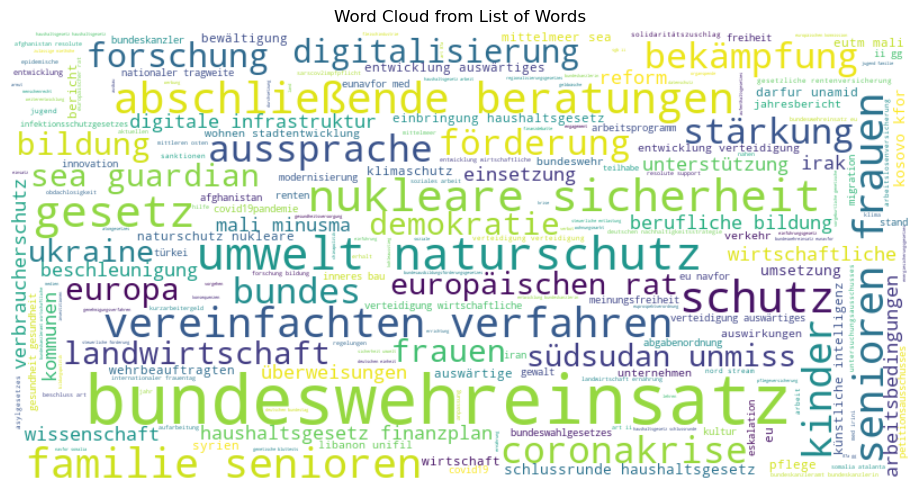

In [39]:
# visualising shared word cloud - speech segmentation

# joining all speech text into a single string
text = ' '.join(all_topic_words)

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=german_stopwords_full).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud from List of Words")
plt.tight_layout()
plt.show()

In [40]:
# add wordcounts per party

# group by party and compute top 10 words per party
top_topics_per_party = {}

for party, group in data.groupby('party'):
    tokens = [word for tokens in group['full_topics'] for word in tokens]
    word_counter = Counter(tokens)
    top_10 = word_counter.most_common(10)
    top_topics_per_party[party] = [f"{word} ({count})" for word, count in top_10]

# create df with results to display
result_df = pd.DataFrame(top_topics_per_party, index=[f"Top {i+1}" for i in range(10)])
result_df
# -> no discrimniation by party possible! no different topics per party, interesting!


AfD                  CDU/CSU  \
Top 1   bundeswehreinsatz (114)  bundeswehreinsatz (286)   
Top 2              bildung (54)            bildung (111)   
Top 3               frauen (42)              frauen (86)   
Top 4            forschung (41)           forschung (74)   
Top 5          entwicklung (40)          sicherheit (72)   
Top 6    verbraucherschutz (39)        europäischen (70)   
Top 7         europäischen (38)         entwicklung (68)   
Top 8      wirtschaftliche (38)                  eu (63)   
Top 9       landwirtschaft (37)     haushaltsgesetz (63)   
Top 10     haushaltsgesetz (36)     wirtschaftliche (63)   

                            FDP                    GRÜNE  \
Top 1   bundeswehreinsatz (113)  bundeswehreinsatz (113)   
Top 2              bildung (56)             bildung (57)   
Top 3               frauen (41)           forschung (46)   
Top 4            forschung (37)              frauen (39)   
Top 5          entwicklung (36)         entwicklung (39)   
Top 6         europäischen (35)         auswärtiges (37)   
Top 7         verteidigung (34)        europäischen (36)   
Top 8           sicherheit (33)          sicherheit (36)   
Top 9      haushaltsgesetz (33)     wirtschaftliche (36)   
Top 10              schutz (31)      landwirtschaft (34)   

                          LINKE                      SPD  
Top 1   bundeswehreinsatz (110)  bundeswehreinsatz (169)  
Top 2              bildung (49)             bildung (93)  
Top 3               frauen (34)           forschung (70)  
Top 4            forschung (34)              frauen (63)  
Top 5           sicherheit (29)        europäischen (62)  
Top 6          entwicklung (28)          sicherheit (61)  
Top 7         europäischen (25)             verkehr (54)  
Top 8                   eu (25)            digitale (52)  
Top 9         verteidigung (25)   verbraucherschutz (51)  
Top 10   verbraucherschutz (25)         entwicklung (50)

### Temporal Analysis of Speeches

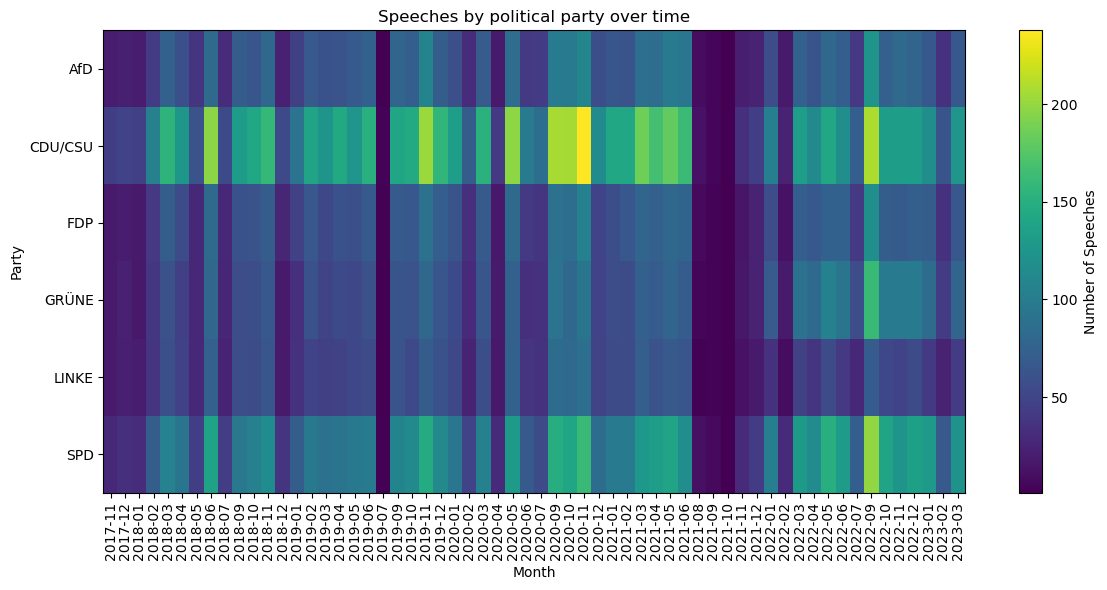

In [41]:
# more better temporal analyses, also with column that Estelle will add
# maybe get sth from Pascal

data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.to_period('M').dt.to_timestamp()
pivot = data.groupby(['month', 'party']).size().unstack(fill_value=0)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(pivot.T, aspect='auto')

# Korrigierte Achsenbeschriftungen für transponierte Matrix
ax.set_xticks(np.arange(len(pivot.index)))
ax.set_xticklabels(pivot.index.strftime('%Y-%m'), rotation=90)
ax.set_yticks(np.arange(len(pivot.columns)))
ax.set_yticklabels(pivot.columns)

ax.set_title("Speeches by political party over time")
ax.set_xlabel('Month')
ax.set_ylabel('Party')

# Colorbar
cbar = fig.colorbar(im, ax=ax, label='Number of Speeches')
plt.tight_layout()
plt.show()

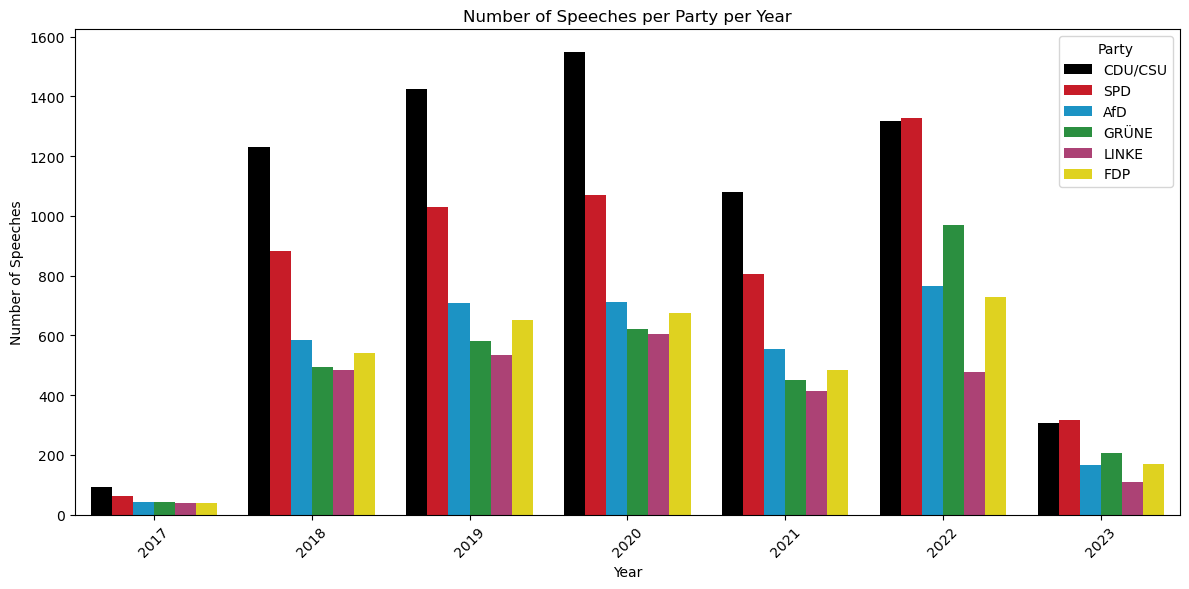

In [42]:
# Extract year from date column 
data['year'] = pd.to_datetime(data['date']).dt.year.dropna()

# Group by Year and Party, count speeches
speech_counts = data.groupby(['year', 'party'])['speech_text'].count().reset_index()
speech_counts.rename(columns={'speech_text': 'SpeechCount'}, inplace=True)
speech_counts['year'] = speech_counts['year'].astype(int)
speech_counts = speech_counts.sort_values(by=['year', 'SpeechCount'], ascending=[True, False])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=speech_counts, x='year', y='SpeechCount', hue='party', palette=party_colors)

plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.title('Number of Speeches per Party per Year')
plt.xticks(rotation=45)
plt.legend(title='Party')
plt.tight_layout()
plt.show()


/var/folders/jp/7rxct1gj4xsc_51ldxz05w9w0000gn/T/ipykernel_2142/3164445475.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  party_time_series = df.groupby('party').resample('M').size().unstack(0).fillna(0)


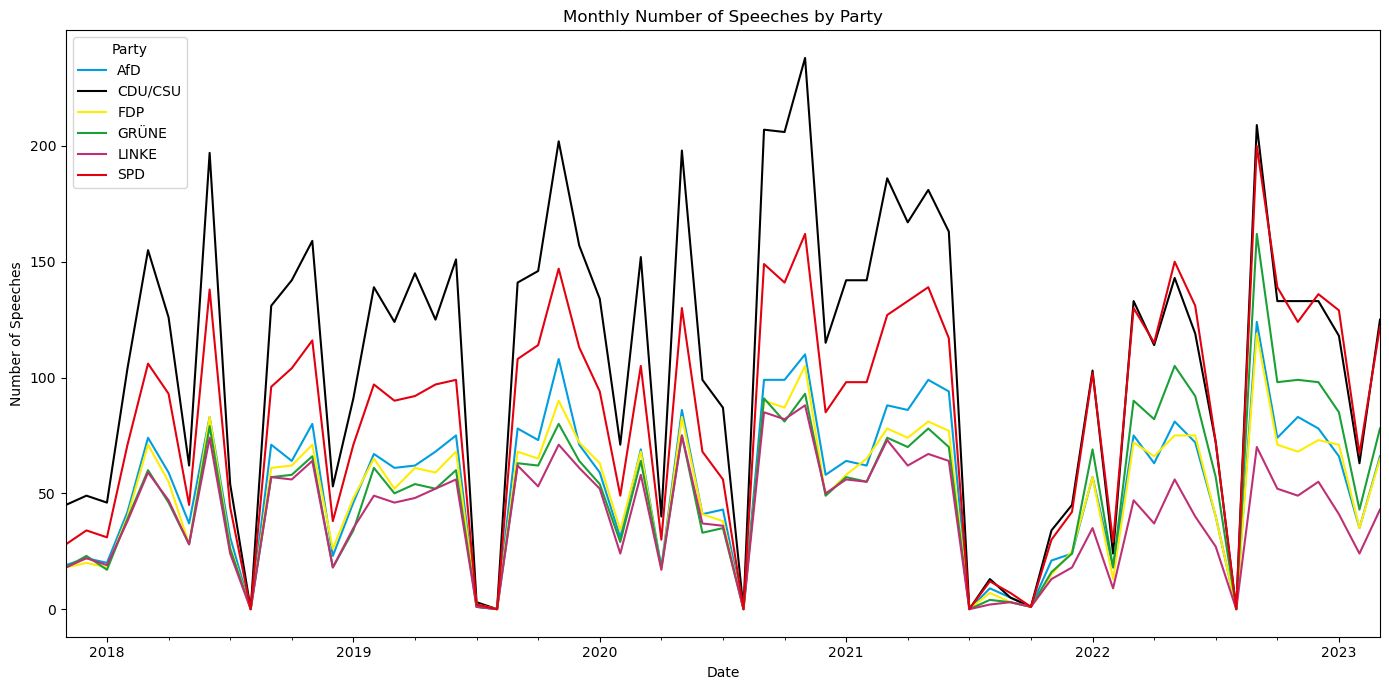

In [43]:
# visualising temporal patterns, by month, grouped by political parties

# perparations:
# setting index to Date for resampling
df = data.set_index('date')
# resampling and counting speeches per month per party
party_time_series = df.groupby('party').resample('M').size().unstack(0).fillna(0)

plt.figure(figsize=(14, 7))
party_time_series.plot(ax=plt.gca(), color=[party_colors.get(party) for party in party_time_series.columns])
plt.title("Monthly Number of Speeches by Party")
plt.xlabel("Date")
plt.ylabel("Number of Speeches")
plt.legend(title="Party")
plt.tight_layout()
plt.show()